Deep learning uses neural networks to train highly effective machine learning models for complex forecasting, computer vision, natural language processing, and other AI workloads.

# Exercise
Use PyTorch to train a deep learning model on Azure Databricks.

- You will use the PyTorch library to train a deep learning model in Azure Databricks. 
- Then you will use the Horovod library to distribute deep learning training across multiple worker nodes in a cluster.

In [0]:
print('hi')

hi


## Ingest and prepare data

The scenario for this exercise is based on observations of penguins in Antarctica, with the goal of training a machine learning model to predict the species of an observed penguin based on its location and body measurements.

In [0]:
%sh
rm -r /Workspace/MicrosoftLearnings/dbfs/deepml_lab
mkdir /Workspace/MicrosoftLearnings/dbfs/deepml_lab
wget -O /Workspace/MicrosoftLearnings/dbfs/deepml_lab/penguins.csv https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/penguins.csv

--2025-09-28 10:20:27--  https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/penguins.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9533 (9.3K) [text/plain]
Saving to: ‘/Workspace/MicrosoftLearnings/dbfs/deepml_lab/penguins.csv’

     0K .........                                             100% 2.65M=0.003s

2025-09-28 10:20:27 (2.65 MB/s) - ‘/Workspace/MicrosoftLearnings/dbfs/deepml_lab/penguins.csv’ saved [9533/9533]



## Prepare data for machine learning
- Remove any incomplete rows
- Encode the (string) island name as an integer
- Apply appropriate data types
- Normalize the numeric data to a similar scale
- Split the data into two datasets: one for training, and another for testing.

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from sklearn.model_selection import train_test_split
   
# Load the data, removing any incomplete rows
df = spark.read.format("csv").option("header", "true").load("file:/Workspace/MicrosoftLearnings/dbfs/deepml_lab/penguins.csv").dropna()
   
# Encode the Island with a simple integer index
# Scale FlipperLength and BodyMass so they're on a similar scale to the bill measurements
islands = df.select(collect_set("Island").alias('Islands')).first()['Islands']
#print('islands'||islands)
print(f'islands: {islands}')

island_indexes = [(islands[i], i) for i in range(0, len(islands))]
print(f'island_indexes: {island_indexes}')

df_indexes = spark.createDataFrame(island_indexes).toDF('Island', 'IslandIdx')
display(df_indexes)

data = df.join(df_indexes, ['Island'], 'left').select(col("IslandIdx"),
                   col("CulmenLength").astype("float"),
                   col("CulmenDepth").astype("float"),
                   (col("FlipperLength").astype("float")/10).alias("FlipperScaled"),
                    (col("BodyMass").astype("float")/100).alias("MassScaled"),
                   col("Species").astype("int")
                    )
display(data.limit(9))

# Oversample the dataframe to triple its size
# (Deep learning techniques like LOTS of data)
for i in range(1,3):
    data = data.union(data)
   
# Split the data into training and testing datasets   
features = ['IslandIdx','CulmenLength','CulmenDepth','FlipperScaled','MassScaled']
label = 'Species'
      
# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(data.toPandas()[features].values,
                                                    data.toPandas()[label].values,
                                                    test_size=0.30,
                                                    random_state=0)
   
print ('Training Set: %d rows, Test Set: %d rows \n' % (len(x_train), len(x_test)))

islands: ['Dream', 'Torgersen', 'Biscoe']
island_indexes: [('Dream', 0), ('Torgersen', 1), ('Biscoe', 2)]


Island,IslandIdx
Dream,0
Torgersen,1
Biscoe,2


IslandIdx,CulmenLength,CulmenDepth,FlipperScaled,MassScaled,Species
1,39.1,18.7,18.1,37.5,0
1,39.5,17.4,18.6,38.0,0
1,40.3,18.0,19.5,32.5,0
1,36.7,19.3,19.3,34.5,0
1,39.3,20.6,19.0,36.5,0
1,38.9,17.8,18.1,36.25,0
1,39.2,19.6,19.5,46.75,0
1,34.1,18.1,19.3,34.75,0
1,42.0,20.2,19.0,42.5,0


Training Set: 957 rows, Test Set: 411 rows 



## Install and import the PyTorch libraries

PyTorch is a framework for creating machine learning models, including deep neural networks (DNNs). Since we plan to use PyTorch to create our penguin classifier, we’ll need to import the PyTorch libraries we intend to use. PyTorch is already installed on Azure databricks clusters with an ML Databricks runtime (the specific installation of of PyTorch depends on whether the cluster has graphics processing units (GPUs) that can be used for high-performance processing via cuda).



In [0]:
# Prepare for using PyTorch

import torch
import torch.nn as nn
import torch.utils.data as td
import torch.nn.functional as F

# Set random seed for reproducability
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.6.0+cpu


## Create data loaders
- PyTorch makes use of data loaders to load training and validation data in batches. 
- We’ve already loaded the data into numpy arrays, but we need to wrap those in PyTorch datasets (in which the data is converted to PyTorch tensor objects) and create loaders to read batches from those datasets.

In [0]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=20, shuffle=False, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20, shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


## Define a neural network

- Now we’re ready to define our neural network. In this case, we’ll create a network that consists of 3 fully-connected layers:

- An input layer that receives an input value for each feature (in this case, the island index and four penguin measurements) and generated 10 outputs.
  - A hidden layer that receives ten inputs from the input layer and sends ten outputs to the next layer.
  - An output layer that generates a vector of probabilities for each of the three possible penguin species.

As we train the network by passing data through it, the forward function will apply RELU activation functions to the first two layers (to constrain the results to positive numbers) and return a final output layer that uses a log_softmax function to return a value that represents a probability score for each of the three possible classes.

In [0]:
# Number of hidden layer nodes
hl = 10
   
# Define the neural network
class PenguinNet(nn.Module):
    def __init__(self):
        super(PenguinNet, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, 3)
   
    def forward(self, x):
        fc1_output = torch.relu(self.fc1(x))
        fc2_output = torch.relu(self.fc2(fc1_output))
        y = F.log_softmax(self.fc3(fc2_output).float(), dim=1)
        return y
   
# Create a model instance from the network
model = PenguinNet()
print(model)

PenguinNet(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Create functions to train and test a neural network model

To train the model, 
- we need to repeatedly feed the training values forward through the network, 
- use a loss function to calculate the loss, 
- use an optimizer to backpropagate the weight and bias value adjustments, 
- and validate the model using the test data we withheld.

To do this, use the following code to create a function to train and optimize the model, and function to test the model.

In [0]:
def train(model, data_loader, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Set the model to training mode
    model.train()
    train_loss = 0
       
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()
   
        # backpropagate adjustments to the weights
        loss.backward()
        optimizer.step()
   
    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
              
               
def test(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0
   
    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)
   
            # calculate the loss
            test_loss += loss_criteria(out, target).item()
   
            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
               
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
       
    # return average loss for the epoch
    return avg_loss

## Train a model
Now you can use the train and test functions to train a neural network model. You train neural networks iteratively over multiple epochs, logging the loss and accuracy statistics for each epoch.



In [0]:
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()
   
# Use an optimizer to adjust weights and reduce loss
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
   
# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
   
# Train over 100 epochs
epochs = 100
for epoch in range(1, epochs + 1):
   
    # print the epoch number
    print('Epoch: {}'.format(epoch))
       
    # Feed training data into the model
    train_loss = train(model, train_loader, optimizer)
       
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
       
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.906871
Validation set: Average loss: 0.757011, Accuracy: 367/411 (89%)

Epoch: 2
Training set: Average loss: 0.669987
Validation set: Average loss: 0.606697, Accuracy: 394/411 (96%)

Epoch: 3
Training set: Average loss: 0.547173
Validation set: Average loss: 0.490729, Accuracy: 400/411 (97%)

Epoch: 4
Training set: Average loss: 0.430030
Validation set: Average loss: 0.376439, Accuracy: 401/411 (98%)

Epoch: 5
Training set: Average loss: 0.318978
Validation set: Average loss: 0.275487, Accuracy: 401/411 (98%)

Epoch: 6
Training set: Average loss: 0.229832
Validation set: Average loss: 0.201355, Accuracy: 403/411 (98%)

Epoch: 7
Training set: Average loss: 0.168079
Validation set: Average loss: 0.152380, Accuracy: 403/411 (98%)

Epoch: 8
Training set: Average loss: 0.127885
Validation set: Average loss: 0.120449, Accuracy: 403/411 (98%)

Epoch: 9
Training set: Average loss: 0.101662
Validation set: Average loss: 0.099471, Accuracy: 403/411 (98%)

E

## let’s try to understand what’s happening:

- In each epoch, the full set of training data is passed forward through the network. There are five features for each observation, and five corresponding nodes in the input layer - so the features for each observation are passed as a vector of five values to that layer. However, for efficiency, the feature vectors are grouped into batches; so actually a matrix of multiple feature vectors is fed in each time.
- The matrix of feature values is processed by a function that performs a weighted sum using initialized weights and bias values. The result of this function is then processed by the activation function for the input layer to constrain the values passed to the nodes in the next layer.
- The weighted sum and activation functions are repeated in each layer. Note that the functions operate on vectors and matrices rather than individual scalar values. In other words, the forward pass is essentially a series of nested linear algebra functions. This is the reason data scientists prefer to use computers with graphical processing units (GPUs), since these are optimized for matrix and vector calculations.
- In the final layer of the network, the output vectors contain a calculated value for each possible class (in this case, classes 0, 1, and 2). This vector is processed by a loss function that determines how far they are from the expected values based on the actual classes - so for example, suppose the output for a Gentoo penguin (class 1) observation is [0.3, 0.4, 0.3]. The correct prediction would be [0.0, 1.0, 0.0], so the variance between the predicted and actual values (how far away each predicted value is from what it should be) is [0.3, 0.6, 0.3]. This variance is aggregated for each batch and maintained as a running aggregate to calculate the overall level of error (loss) incurred by the training data for the epoch.
- At the end of each epoch, the validation data is passed through the network, and its loss and accuracy (proportion of correct predictions based on the highest probability value in the output vector) are also calculated. It’s useful to do this because it enables us to compare the performance of the model after each epoch using data on which it was not trained, helping us determine if it will generalize well for new data or if it’s overfitted to the training data.
- After all the data has been passed forward through the network, the output of the loss function for the training data (but not the validation data) is passed to the optimizer. The precise details of how the optimizer processes the loss vary depending on the specific optimization algorithm being used; but fundamentally you can think of the entire network, from the input layer to the loss function as being one big nested (composite) function. The optimizer applies some differential calculus to calculate partial derivatives for the function with respect to each weight and bias value that was used in the network. It’s possible to do this efficiently for a nested function due to something called the chain rule, which enables you to determine the derivative of a composite function from the derivatives of its inner function and outer functions. You don’t really need to worry about the details of the math here (the optimizer does it for you), but the end result is that the partial derivatives tell us about the slope (or gradient) of the loss function with respect to each weight and bias value - in other words, we can determine whether to increase or decrease the weight and bias values in order to minimize the loss.
- Having determined in which direction to adjust the weights and biases, the optimizer uses the learning rate to determine by how much to adjust them; and then works backwards through the network in a process called backpropagation to assign new values to the weights and biases in each layer.
- Now the next epoch repeats the whole training, validation, and backpropagation process starting with the revised weights and biases from the previous epoch - which hopefully will result in a lower level of loss.
- The process continues like this for 100 epochs.

## Review training and validation loss

- After training is complete, we can examine the loss metrics we recorded while training and validating the model. We’re really looking for two things:
- The loss should reduce with each epoch, showing that the model is learning the right weights and biases to predict the correct labels.
- The training loss and validation loss should follow a similar trend, showing that the model is not overfitting to the training data.

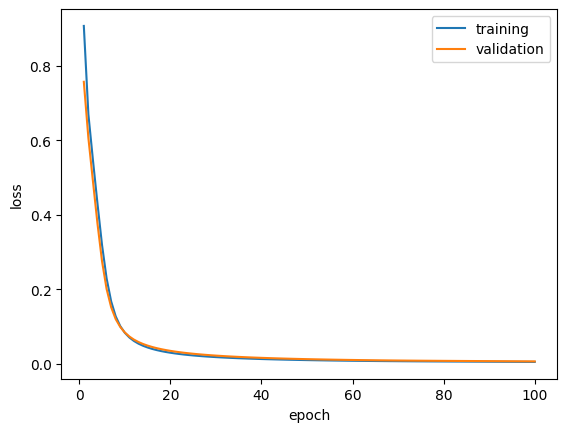

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
   
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## View the learned weights and biases

The trained model consists of the final weights and biases that were determined by the optimizer during training. Based on our network model we should expect the following values for each layer:

- Layer 1 (fc1): There are five input values going to ten output nodes, so there should be 10 x 5 weights and 10 bias values.
- Layer 2 (fc2): There are ten input values going to ten output nodes, so there should be 10 x 10 weights and 10 bias values.
- Layer 3 (fc3): There are ten input values going to three output nodes, so there should be 3 x 10 weights and 3 bias values.

Code to view the layers in your trained model:

In [0]:
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

fc1.weight 
 [[-3.3482078e-03  2.3990487e-01 -3.6807698e-01 -3.2912195e-01
  -1.7224626e-01]
 [ 9.8052907e-01  7.1882396e-03  4.7429168e-01  7.4422829e-02
   1.9298296e-01]
 [-1.3515380e-01 -8.7906711e-02 -4.2724484e-01 -2.9618156e-01
  -1.8435177e-01]
 [-8.7300920e-01  2.5517979e-01  5.3543192e-01 -2.8044116e-01
  -2.4244229e-01]
 [ 1.0778535e-01  4.8213866e-01 -3.2809243e-01  3.4801868e-01
   1.0674807e-01]
 [-6.9977832e-01  4.8596060e-01 -6.0618669e-01 -3.0907732e-01
  -4.7691600e-04]
 [-1.6022652e+00  4.9901575e-01 -2.6839456e-01 -2.0371209e-01
  -2.6576379e-01]
 [-2.1240403e-01 -3.4114641e-01  6.9110030e-01  2.2590327e-01
   4.4996012e-02]
 [ 2.3519661e-02 -2.2927903e-01  7.5661689e-02 -4.1756096e-01
  -3.2314146e-01]
 [-7.5280923e-01  2.1307275e-01  5.8127105e-01 -2.6024109e-01
  -2.1337733e-01]]
fc1.bias 
 [ 0.28602025  0.64911675  0.1774911   0.15111372  0.10917635 -0.46513873
 -0.01083796 -0.09598634 -0.30995753 -0.09365477]
fc2.weight 
 [[ 0.14308454  0.20836797 -0.18731831  

## Save and use the trained model
- Now that we have a trained model, we can save its trained weights for use later.
- Code to save the model:

In [0]:
# Save the model weights
model_file = '/Workspace/MicrosoftLearnings/dbfs/deepml_lab/penguin_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as /Workspace/MicrosoftLearnings/dbfs/deepml_lab/penguin_classifier.pt


### Use the following code to load the model weights and predict the species for a new penguin observation:

In [0]:
# New penguin features
x_new = [[1, 50.4,15.3,20,50]]
print ('New sample: {}'.format(x_new))
   
# Create a new model class and load weights
model = PenguinNet()
model.load_state_dict(torch.load(model_file))
   
# Set model to evaluation mode
model.eval()
   
# Get a prediction for the new data sample
x = torch.Tensor(x_new).float()
_, predicted = torch.max(model(x).data, 1)
   
print('Prediction:',predicted.item())

New sample: [[1, 50.4, 15.3, 20, 50]]
Prediction: 1


In [0]:
display(df_indexes)

Island,IslandIdx
Dream,0
Torgersen,1
Biscoe,2
